In [3]:
import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

path = "/home/etienne/projects/obsq/work/dev/data/data.duckdb"
target = 'score'
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [4]:
table = 'combined_p'
schema = 'features'
con = duckdb.connect(path)
df = con.execute(f"""SELECT* FROM {schema}.{table}""" ).df()
#df = df.drop(columns= 'geom')
con.close()

In [5]:
df.set_index('gbifID', inplace=True)

In [ ]:
X = df.drop(columns=[target])
y = df.pop(target)
X.head()

,observer_pca0,observer_pca1,observer_inat_pca0,observer_inat_pca1,taxo_freq,taxo_confusability_index,cmva_id_count,cmva_id_agree_rate,cmva_id_time,cmva_expert_id,...,decimalLongitude,spatial_cluster,gee_pca0,gee_pca1,gee_pca2,gee_pca3,range,pheno_leaves_month_density,pheno_repro_month_density,pheno_sex_month_density
gbifID,,,,,,,,,,,,,,,,,,,,,
4171987115,-109.72757,23.60172,1.18067,0.01650,0.00900,0,1,1.00000,0,0,...,-72.86259,1,-50.92825,-4.96717,1.84532,9.69664,1,0.00000,0.00000,0.00000
5759678836,-151.45404,959.49953,3.45784,-0.46756,6.15200,24,1,1.00000,28,0,...,-72.23862,3,580.36551,14.24096,-51.51520,11.17725,1,0.14900,0.14800,0.00000
4901298379,-151.45404,959.49953,3.45784,-0.46756,2.87000,16,1,1.00000,1,0,...,-72.77512,1,-59.98569,3.84987,15.84660,11.06869,1,0.14100,0.53600,0.00000
4891980652,-152.76963,339.98951,2.68004,-0.15409,2.07600,24,1,1.00000,1,0,...,-73.26773,4,-157.15425,9.08711,-21.68603,-2.56467,1,0.21900,0.10900,0.00000
4904246759,-152.76963,339.98951,2.68004,-0.15409,0.01900,0,1,1.00000,1,0,...,-73.26408,4,-160.56056,8.21573,-18.47267,-2.21227,1,0.00000,0.00000,0.00000


<Axes: >

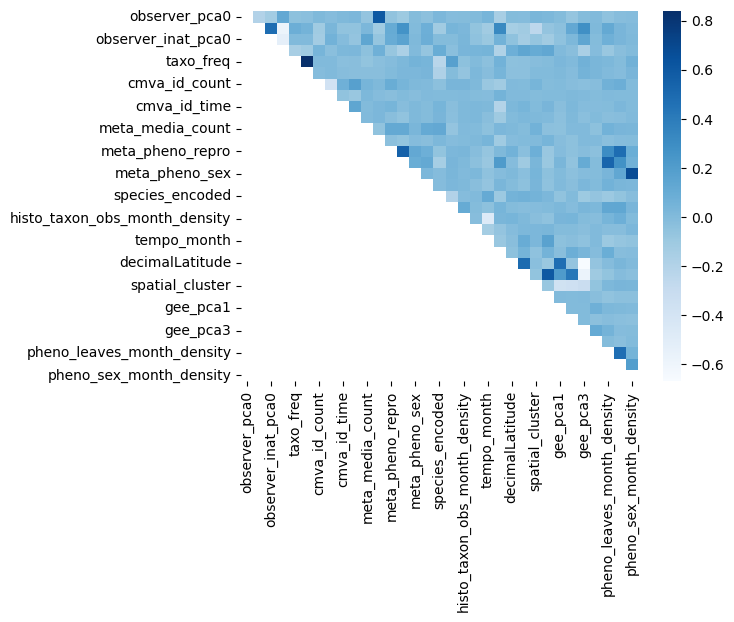

In [9]:
corr = X.corr(numeric_only=True)
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

sns.heatmap(upper_tri, cmap='Blues',)

In [10]:
highly_correlated_pairs = upper_tri.stack().sort_values(ascending=False)
highly_correlated_pairs

taxo_freq                      taxo_confusability_index              0.83861
meta_pheno_sex                 pheno_sex_month_density               0.67722
decimalLongitude               gee_pca0                              0.60173
observer_pca0                  meta_coordinateUncertaintyInMeters    0.59821
meta_pheno_repro               meta_pheno_leaves                     0.55487
                                                                      ...   
histo_taxon_obs_month_density  tempo_month                          -0.47393
observer_inat_pca0             observer_inat_pca1                   -0.53087
decimalLongitude               gee_pca3                             -0.57720
observer_pca1                  observer_inat_pca1                   -0.58518
decimalLatitude                gee_pca3                             -0.66853
Length: 528, dtype: float64

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [12]:
scaler = StandardScaler()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
n_samples = len(y_train)
n_pos = y_train.sum()
n_neg = n_samples - n_pos
scale_pos_weight = n_neg / n_pos

In [ ]:
model = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
            )

In [ ]:
model = XGBRegressor(
                n_estimators=500,
                max_depth=6,
                scale_pos_weight=scale_pos_weight,
                learning_rate=0.1,
                random_state=42,
                eval_metric='logloss')


In [ ]:
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Calculate evaluation metrics

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r_squared)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.0760802445015894
Mean Squared Error (MSE): 0.009972308156786807
R-squared (R²): 0.7002435340329267
Root Mean Squared Error (RMSE): 0.09986144479621155


In [ ]:
print(X_test.shape)
print(y_test.shape)

(8970, 29)
(8970,)


In [ ]:
y_pred

array([0.4546569 , 0.24149366, 0.47230944, ..., 0.20040923, 0.38653994,
       0.26550502], dtype=float32)

In [ ]:
results = X_test.copy()
results['true'] = y_test
results['predicted'] = y_pred


<Axes: xlabel='true', ylabel='predicted'>

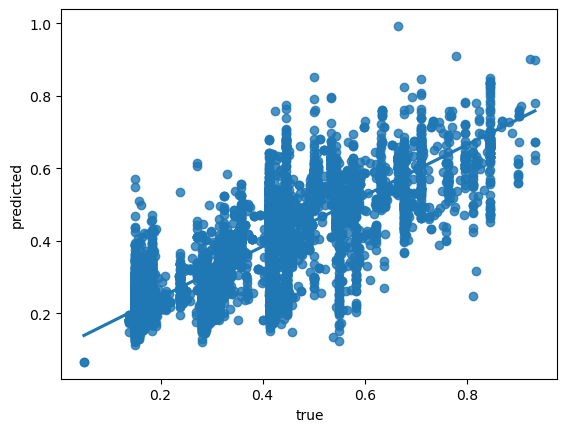

In [ ]:
# Plot outputs
sns.regplot(results, x = 'true', y = 'predicted')